# Day1: Regression and Classification

<button disabled>

**Author:** [Modar Alfadly](http://modar.me) and [Hasan Abed Al Kader Hammoud](https://scholar.google.com/citations?user=Plf1JSIAAAAJ&hl=en)

</button>

To setup a conda environment for this project, just run the following commands:

```shell
conda create -n cs323 python=3.9.1 -y
conda activate cs323

conda install pytorch torchvision torchaudio cudatoolkit=11.0 -c pytorch -c conda-forge -y  # install PyTorch 1.7.1
conda install jupyter -y  # to edit this file
conda install jedi=0.17.2 -y  # https://github.com/ipython/ipython/issues/12740
conda install matplotlib -y  # for plotting
conda install requests -y  # to download Google Drive files

pip install jupyter_http_over_ws  # for Google Colab
jupyter serverextension enable --py jupyter_http_over_ws  # Google Colab
```

## Remarks


Welcome to day 1 in the computer vision week, this is your first assignment where you will learn/review the basics of PyTorch and some Deep Learning techniques.

# Part 1: Regression (3 points)

## Task 1: gradient descent (1 point)

One of the benefits of using PyTorch is the [automatic differentiation](https://medium.com/@ODSC/automatic-differentiation-in-pytorch-6131b4581cdf) feature. Suppose, that you want to compute the derivative of a composite function with respect to one of its inputs. As long as you can construct the function in PyTorch's basic operations, you can ask it to compute any gradient for you very efficiently.

Let's take this function as an example:
$$f(x) = \frac{\arctan\left(x^{3}\right)}{x}$$



In [ ]:
import torch

from matplotlib import pyplot as plt


def f(x):
    return torch.arctan(x**3) / x


xs = torch.linspace(start=-5, end=5, steps=100)
ys = f(xs)

plt.plot(xs, ys, label='$f(x)$')
plt.xlabel('$x$')
plt.legend()
plt.grid()
plt.show()

We can rewrite it as a composition of functions (forward-pass).
$$f(x) = g(h(k(x)), x) ~\text{where}~ k(x) = x^3, h(x) = \arctan\left(x\right), g(x, y) = \frac{x}{y}$$

Now we can find its derivative by leveraging the [chain rule](https://en.wikipedia.org/wiki/Chain_rule) (backward-pass).
$$\frac{d f(x)}{dx} = \frac{3x}{x^6 + 1} - \frac{\arctan\left(x^{3}\right)}{x^2}$$

PyTorch implements the [backpropagation](https://en.wikipedia.org/wiki/Backpropagation) algorithm which repeatedly applys the chain rule to automatically compute gradients at a given point. Internally, it dynamically represents the function as a graph where the nodes are the tensors and the edges are the operations that are done to them. Since it knows the partial derivatives of each operation to its inputs (e.g. $g$, $h$, and $k$), propagating the output gradients becomes a mechanical task.

In [ ]:
xs = torch.linspace(-5, 5, steps=100, requires_grad=True)
ys = f(xs)

# TODO: understand this line.
# read the docs Tensor.backward: https://pytorch.org/docs/stable/tensors.html
ys.backward(torch.ones_like(ys))

plt.plot(xs.data, xs.grad, label='$f\'(x)$')
plt.legend()
plt.grid()
plt.show()

We need the ability to compute gradients to apply the [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent) algorithm which is the most fundamental optimization tool for machine learning.

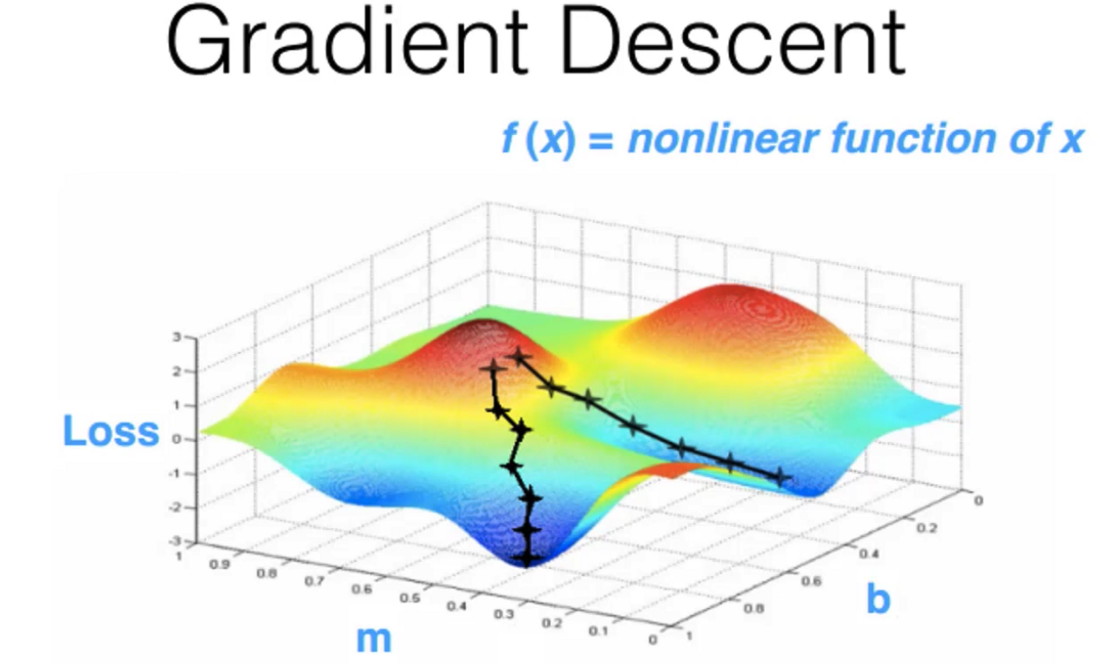

Let's start with a slightly modified function where the goal is to find a local minimum point using gradient descent.
$$f(x) =\text{sign}(x) \frac{\arctan\left(x^{3}\right)}{x}$$

Of course, we can find the minimizer of this functoin by checking where the gradient is zero. However, this is just an example with a single variable. In a real scenario, we don't have an analytical closed form solution for the gradient and the function could have millions and maybe billions of parameters.

In [ ]:
def f(x):
    return torch.sign(x) * torch.arctan(x**3) / x


# TODO: vvvvvvvvvvv
# plot the function f(x) as before

# ^^^^^^^^^^^^^^^^^

In [ ]:
# TODO: understand this line.
def gradient_descent(initial_point, step_size, num_iterations):
    losses = []
    if not torch.is_tensor(initial_point):
        initial_point = torch.full((), initial_point, dtype=torch.float)
    x = initial_point.data.clone().requires_grad_(True)
    for i in range(num_iterations):
        loss = f(x)  # compute the objective (forward-pass)

        x.grad = None  # zero out the gradient
        loss.backward()  # compute the gradient (backward-pass)
        x.data = x.data - step_size * x.grad  # take one step

        losses.append(loss.item())
    return x.detach(), losses

Let's now use this method to find the minimum value of our function using different initializations and hyper-parametrs (e.g., learning rate, number of iterations).

In [ ]:
# TODO: how does the initialization changes the result
# TODO: how should we choose the learning rate and the iterations
# TODO: what happens when we initialize at 0
steps = 100
learning_rate = 0.1
for x_0 in [-4, -1, 0, 1, 4]:
    x_n, losses = gradient_descent(
        initial_point=x_0,
        step_size=learning_rate,
        num_iterations=steps,
    )

    # plot the results
    xs = torch.linspace(-5, 5, steps=100)
    plt.plot(xs, f(xs), label='$f(x)$')
    plt.scatter([x_0], [losses[0]], color='red', marker='x', label='start')
    plt.scatter([x_n], [losses[-1]], color='red', marker='^', label='end')
    plt.title(f'start: $x={x_0:.2f}$ end: $x={x_n:.2f}$')
    plt.legend()
    plt.show()

    # TODO: vvvvvvvvvvv
    # plot the training loss [x-axis:iteration, y-axis:loss_value]

    # ^^^^^^^^^^^^^^^^^
    print('###########################')

## Task 2: `torch.nn.Module`, `torch.optim.Optimizer`, and `torch.utils.data` (2 points)

PyTorch has many variants of gradient descent optimizers like gradient descent with Nesterov momentum and Adam. You can learn more about them in the [documentation](https://pytorch.org/docs/stable/optim.html) or in this [blog post](https://ruder.io/optimizing-gradient-descent/). They all inherent from the base [`torch.optim.Optimizer`](https://pytorch.org/docs/stable/optim.html#torch.optim.Optimizer) class. We want to change the code above to conform to the conventional PyTorch pipeline.

However, as we mentioned before, in real scenarios, the functions that we try to minimize are more complicated. They are parametric models with the following form $y \approx f(x; \theta)$, where $x$ contains the independent input variables (features), $\theta$ contains the parameters that we need to learn, and $y$ contains the dependent output variables. [Regression](https://en.wikipedia.org/wiki/Regression_analysis) is a perfect example of such problem, where we want to fit a parametric function (model) to some given data (training). The data are given to us as a finite set of $(x, y)$ pairs. For a chosen analytical form of $f(x; \theta)$ (e.g. linear $f(x; \theta) = m x + b$ where $\theta = \{m, b\}$), we want to find the best value of $\theta$ that makes $f(x; \theta)$ as close as possible to $y$ according to some criterion ([loss function](https://en.wikipedia.org/wiki/Loss_function) such as the mean squared error $\left(f(x; \theta) - y\right)^2$). Since we have limited data, we usually train for multiple episodes (epochs); every epoch is one full run over the entire training dataset. Finally, each epoch can be done in a single iteration (standard gradient descent) or multiple iterations (the data could be batched or each iteration will train only on a single input-ouput pair). See [stochastic gradient descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent).

In the previous task (Part1.Task1), we didn't have input features $x$ or output variables $y$ (no data). In fact, our old input $x$ is what we refer to here as the parameter $\theta$. So, let's add those edits to our gradient_descent function.

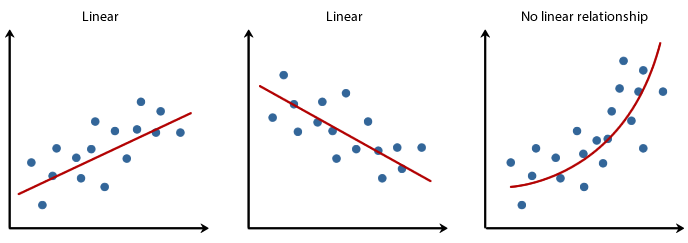

In [ ]:
# TODO: understand every line of the following method
def gradient_descent(model, learning_rate, num_epochs, data_loader, criterion):
    losses = []
    optimizer = torch.optim.SGD(model.parameters(), learning_rate)
    for epoch in range(num_epochs):  # one epoch
        for inputs, outputs in data_loader:  # one iteration
            loss = criterion(model(inputs), outputs)  # forward-pass

            optimizer.zero_grad()  # zero out the gradients
            loss.backward()  # compute the gradients (backward-pass)
            optimizer.step()  # take one step

            losses.append(loss.item())
        loss = sum(losses[-len(data_loader):]) / len(data_loader)
        print(f'Epoch #{epoch}: Loss={loss:.3e}')
    return losses

Let's solve the following regression problem. Find the closest third-degree polynomial to $f(x) = x^6 - 3x^5 - x^3 + 3x$ in the range $[-2, 2]$.

In [ ]:
import torch.nn as nn

# TODO: understand the Models here (PolynomialModel, Linearmodel, init, nn.Parameter, forward pass ...)
class PolynomialModel(nn.Module):
    """Generic model for a polynomial of any degree."""
    def __init__(self, degree):
        super().__init__()
        assert int(degree) == degree and degree >= 0  # sanity check

        # define the model parameters (order-decreasing)
        # all sub_modules and parameters must be direct attributes of self
        self.coefficients = nn.Parameter(torch.ones([degree + 1]))

    def forward(self, x):
        coefficients = iter(self.coefficients)
        out = torch.zeros_like(x)
        out += next(coefficients, 0)
        for c in coefficients:
            out *= x
            out += c
        return out


class Linearmodel(PolynomialModel):
    """Scalar linear model `f(x) = m x + b`."""
    def __init__(self):
        super().__init__(degree=1)

Let's generate the training dataset. We will first define the ground-truth model and freeze its parameters. Then, use it to generate point pairs in the range $[-2, 2]$.

In [ ]:
from torch.utils.data import TensorDataset, DataLoader


f = PolynomialModel(degree=6)
f.coefficients.requires_grad_(False)
f.coefficients.data = torch.FloatTensor([1, -3, 0, -1, 0, 3, 0])

torch.manual_seed(0)
xs = 2 * (torch.rand(1000) * 2  - 1)
dataset = TensorDataset(xs, f(xs))

In [ ]:
# TODO: study the following parameters of the data loader
# https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader
# the goal of the data loader is to batch multiple samples "(x, y) pairs"
# on the fly and make them ready for training by using multiprocessing
# it is important to differentiate between Dataset() and DataLoader()
data_loader = DataLoader(
    dataset,
    batch_size=20,
    shuffle=True,
    num_workers=1,
    drop_last=True,
    pin_memory=False,
    collate_fn=None,
)

In [ ]:
# TODO: vvvvvvvvvvv
# understand and change the following
# you must achieve a mean squared error of at most 61

torch.manual_seed(0)
model = PolynomialModel(degree=3)
losses = gradient_descent(
    model,
    learning_rate=0.001,
    num_epochs=10,
    data_loader=data_loader,
    criterion=nn.MSELoss(),
)
# ^^^^^^^^^^^^^^^^^

loss = sum(losses[-len(data_loader):]) / len(data_loader)
print(f'Average loss for last epoch: {loss}')

# plot the training loss
plt.plot(range(len(losses)), losses, label='loss')
plt.xlabel('iteration')
plt.legend()
plt.show()

# plot the ground-truth model vs the learned model
xs = torch.linspace(-2, 2, steps=100)
plt.plot(xs, f(xs), label='ground-truth')
plt.plot(xs, model(xs).data, label='learned')
plt.legend()
plt.show()

In [ ]:
# TODO: vvvvvvvvvvv
# create a testing set in the range [-4, 4] and its data loader

# ^^^^^^^^^^^^^^^^^

# TODO: vvvvvvvvvvv
# plot the ground-truth model vs the learned model in the new range

# ^^^^^^^^^^^^^^^^^

# TODO: what is overfitting https://wikipedia.org/wiki/Overfitting

Let's try a different model to fit this sixth-degree polynomial. We will use a plain feed-forwad artificial neural network (a.k.a., fully-connected network and multi-layer perceptron). The model simply a composition of linear layers (actually affine) followed by non-linear functions ([activation functions](https://en.wikipedia.org/wiki/Activation_function); [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) is the most commonly used one). The dimension sizes between layers could increase or decrease as long as the input and output dimensions are consistent with the data (in this case, 1D input and 1D output). The number of layers is referred to as the **depth** of the network (hence, the term deep learning) and the dimension size is the **width**. We will not concern ourselves in this exercise with splitting the data into training and testing. We will leave this for the next parts.

In [ ]:
# TODO: vvvvvvvvvvv
# this is a two hidden-layer fully-connected neural network
# try to change the model configuration and the hyper-parameters
# to get a mean squared error of at most 10
torch.manual_seed(0)
model = nn.Sequential(
    # TODO: what is the total number of parameters?
    nn.Linear(in_features=1, out_features=3),
    nn.ReLU(inplace=True),
    nn.Linear(in_features=3, out_features=5),
    nn.ReLU(inplace=True),
    nn.Linear(in_features=5, out_features=1),
)

xs = 2 * (torch.rand(1000, 1) * 2  - 1)
dataset = TensorDataset(xs, f(xs))

data_loader = DataLoader(
    dataset,
    batch_size=20,
    shuffle=True,
    num_workers=1,
    drop_last=True,
    pin_memory=False,
    collate_fn=None,
)
losses = gradient_descent(
    model=model,
    learning_rate=0.001,
    num_epochs=10,
    data_loader=data_loader,
    criterion=nn.MSELoss(),
)
# ^^^^^^^^^^^^^^^^^

loss = sum(losses[-len(data_loader):]) / len(data_loader)
print(f'Average loss for last epoch: {loss}')

# plot the training loss
plt.plot(range(len(losses)), losses, label='loss')
plt.xlabel('iteration')
plt.legend()
plt.show()

# plot the ground-truth model vs the learned model
xs = torch.linspace(-2, 2, steps=100).unsqueeze(1)
plt.plot(xs, f(xs), label='ground-truth')
plt.plot(xs, model(xs).data, label='learned')
plt.legend()
plt.show()

# Part 2: Image Classification (5 points)

## Task 1: Logistic Regression (1.5 points)

It is now time to move on from regression to classification; the problem of assigning class labels to data points (input features). The simplest form of classification is binary classification, where each input can only be assigned one of two classes. For example, given an N-D point $\mathbf{x}$, it has class label 0 if it is inside the N-D $\ell_2$ unit sphere (i.e., $\|\mathbf{x}\|_2 < 1$ and class label 1 otherwise. Or given an image, we assign it class 1 if it contains a cat and class 0 if it doesn't. One of the basic statistical models for this task is [logistic regression](https://en.wikipedia.org/wiki/Logistic_regression). It was named as such because of the use of the [logistic function](https://en.wikipedia.org/wiki/Logistic_function) (a.k.a, sigmoid) as the last activation function. Sigmoid is a squashing function where the output range is limited in the range $[0, 1]$. So, this is why it is a perfect solution for binary classification. The output of a trained model with the sigmoid as its final layer (logits), can be thought of as the probability $p$ that the input belongs to class 1. The probability of it belonging to class 0 is going to trivially be $1 - p$. To that end, it is fitting to use the [cross entropy](https://en.wikipedia.org/wiki/Cross_entropy) loss as a criterion instead of the mean squared error loss.

In [ ]:
from pathlib import Path
from torchvision import datasets
import torchvision.transforms as T


root_dir = Path(torch.hub.get_dir()) / f'datasets/MNIST'
train_set = datasets.MNIST(
    root_dir,
    train=True,
    download=True,
    # TODO: understasnd what is transform why is it needed?
    # https://stackoverflow.com/a/4674770
    transform=T.Compose([
        T.ToTensor(),
        T.Normalize([0.1307], [0.3081]),
    ]),
)

print(train_set)

We will be using the MNIST dataset which is a ($28 \times 28$ gray-scale hand-written digits dataset). It has 60K labeled images for training and 10K for testing. It has 10 classes (the digits 0, 1, ..., 9). Rerun the following cell multiple times to see few examples.

In [ ]:
index = torch.randint(0, len(train_set), ())
image, label = train_set[index]

# TODO: understand the permute() here.
plt.imshow(image.permute((1, 2, 0)), cmap='gray')
plt.title(f'Digit: {label}')
plt.axis('off')
plt.show()

Since the task is binary classification, we will group the digits $\{0, 1, 2, 3, 4\}$ in class 0 and the digits $\{5, 6, 7, 8, 9\}$ in class 1.

In [ ]:
import torch.nn.functional as F


torch.manual_seed(0)
# TODO: understand the model here.
model = nn.Sequential(
    nn.Flatten(1),
    nn.Linear(28 * 28, 256),
    nn.ReLU(inplace=True),
    nn.Linear(256, 64),
    nn.ReLU(inplace=True),
    nn.Linear(64, 1),
    nn.Flatten(0),
)

# TODO: vvvvvvvvvvv
# it is recommended to use F.binary_cross_entropy_with_logits(x, y)
# over F.binary_cross_entropy(torch.sigmoid(x), y)
# why?
# change it below
def criterion(x, y):
    x = torch.sigmoid(x)
    y = (y >= 5).to(dtype=torch.float)
    return F.binary_cross_entropy(x, y)
# ^^^^^^^^^^^^^^^^^

train_loader = DataLoader(
    train_set,
    batch_size=128,
    shuffle=True,
    num_workers=4,
    drop_last=True,
    pin_memory=False,
    collate_fn=None,
)

losses = gradient_descent(
    model,
    learning_rate=0.001,
    num_epochs=3,
    data_loader=train_loader,
    criterion=criterion,
)

plt.plot(losses, label='loss')
plt.legend()
plt.show()

Let's see how we are doing on the test set in terms of classificaiton accuracy.

In [ ]:
test_set = datasets.MNIST(
    root_dir,
    train=False,
    download=True,
    transform=T.Compose([
        T.ToTensor(),
        T.Normalize([0.1307], [0.3081]),
    ]),
)

test_loader = DataLoader(
    test_set,
    batch_size=128,
    shuffle=False,
    num_workers=4,
    drop_last=False,
    pin_memory=False,
    collate_fn=None,
)


In [ ]:
# evaluation mode
# compute the classification accuracy
total = 0
correct_count = 0
model.train(False)  # TODO: why?
with torch.no_grad():  # TODO: why?
    for images, labels in test_loader:
        # TODO: understand how the calculation is being done.
        prediction = model(images) >= 0.5
        ground_truth = labels >= 5
        correct_count += (prediction == ground_truth).sum().item()
        total += len(labels)
accuracy = correct_count / total
print(f'{accuracy * 100:.2f}% (random classifier gives you 50%)')

# TODO: change the previous cell and note your changes here
# the goal is to reach 95% accuracy on the training set

## Task 2: Softmax and Cross-Entropy (1.5 points)

A slightly more difficult classification problem than binary classification is multi-class classification (each sample can is assigned only one of many class labels possibly greater than 2). In such case, the size of the output is set to be equal to the number of classes, where the class prediction is the dimension with the maximum value. If we apply a hard max operator on the output, we should get 1 at the maximum value and 0's everywhere else (a.k.a [one-hot encoding](https://en.wikipedia.org/wiki/One-hot)). To get a probability as we did before, we apply a soft version of the max function (called [softmax](https://en.wikipedia.org/wiki/Softmax_function)), which normalizes the output values to sum to 1 and forces them to be in the range $[0, 1]$. With this setup, we can use the cross entropy criterion as our loss function. This is the most common setup for multi-class classification problems. It is only marginally modified for multi-label classification problems (one sample can be assigned more than one class), where a bed-of-nails is used as the target and the used criterion is the binary cross entropy loss. Regardless, we will only focus on the multi-class problem.

In [ ]:
# TODO: vvvvvvvvvvv
# do your magic here, the goal is 95% accuracy
# you can change the model (only using Flatten, Linear, and ReLU), the optimizer, the hyper-paremeters
torch.manual_seed(0)
model = nn.Sequential(
    nn.Flatten(1),
    nn.Linear(28 * 28, 256),
    nn.ReLU(inplace=True),
    nn.Linear(256, 64),
    nn.ReLU(inplace=True),
    nn.Linear(64, 10),
    # no need to add nn.Softmax() here
)

# this has softmax inside it already
criterion = nn.CrossEntropyLoss()

losses = gradient_descent(
    model,
    learning_rate=0.001,
    num_epochs=3,
    data_loader=train_loader,
    criterion=criterion,
)
# ^^^^^^^^^^^^^^^^^

plt.plot(losses, label='loss')
plt.legend()
plt.show()

# compute the classification accuracy
total = 0
correct_count = 0
model.train(False)
with torch.no_grad():
    for images, labels in test_loader:
        prediction = model(images).argmax(1)
        correct_count += (prediction == labels).sum().item()
        total += len(labels)
accuracy = correct_count / total
print(f'{accuracy * 100:.2f}% (random classifier gives you 10%)')

Our models are getting heavier and they started needing some hardware acceleration. It is time to update `gradient_descent()` and rewrite it to:

1. Start training on the GPU
1. Log the progress after every epoch (loss and classification accuracy)
1. Expect a validaiton data loader (inspect overfitting)
1. use a more sophisticated optimizer (e.g., Adam)
1. Put the model in training mode (some layers have different behavior between training and testing)
1. Disable unnecessarily computing gradients in evaluation mode

Advanced features that we will add in future projects.
1. Expect a learning rate scheduler (dynamically changing the learning rate)
1. Ability to save checkpoints as training progresses in case of failures
1. Ability to resume training from a saved checkpoint
1. Perform early stopping (in case of overfitting or diverging training)
1. Expect command line arguments from `argparse`

For the avid reader, check [this](http://bit.ly/dl_for_cv_05) out if you are interested in seeing an implementation of these features.

We will create a function that can be called in one of two modes; when `torch.is_grad_enabled()` is True and when it is not. The first mode is for training and the second is for validation. For now, we will use the testing dataset as our validation split (yeah, we are cheating a bit).

In [ ]:
# TODO: vvvvvvvvvvv
# you should be able to explain all the introduced changes
# read: https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
# TODO: add lr_scheduler as an optional input and call its step()
def gradient_descent(model, loaders, optimizer, device, epochs):
    metrics = {'loss': [], 'accuracy': [], 'v_loss': [], 'v_accuracy': []}
    train = torch.is_grad_enabled()
    model.train(train)
    for epoch in range(epochs):  # one epoch
        count = avg_loss = avg_accuracy = 0
        for inputs, outputs in loaders[not train]:  # one iteration
            # move the inputs and outputs tensors to device
            inputs, outputs = inputs.to(device), outputs.to(device)
            logits = model(inputs)  # forward-pass
            loss = F.cross_entropy(logits, outputs)  # compute objective

            if train:
                optimizer.zero_grad()  # zero out the gradients
                loss.backward()  # compute the gradients (backward-pass)
                optimizer.step()  # take one step

            # update the metrics
            count += len(outputs)
            avg_loss += loss.item()
            avg_accuracy += (logits.data.argmax(1) == outputs).sum().item()

        # accumulate the metrics
        avg_loss *= len(loaders[not train])
        avg_accuracy /= count
        metrics['loss'].append(avg_loss)
        metrics['accuracy'].append(avg_accuracy)

        if train:
            # perform a validation epoch if done training
            with torch.no_grad():
                # TODO: this function calls itself? explain
                v_metrics = gradient_descent(model, loaders, None, device, 1)
                metrics['v_loss'].append(v_metrics['loss'][0])
                metrics['v_accuracy'].append(v_metrics['accuracy'][0])

            # log the progress
            msg = '{}[loss={:.3e} @ accuracy={:.2f}%]'
            loss, accuracy = metrics['loss'][-1], metrics['accuracy'][-1]
            train_values = msg.format('Train', loss, accuracy * 100)
            loss, accuracy = metrics['v_loss'][-1], metrics['v_accuracy'][-1]
            val_values = msg.format('Val', loss, accuracy * 100)
            print(f'Epoch #{epoch}: {train_values} {val_values}')
    return metrics
# ^^^^^^^^^^^^^^^^^

In [ ]:
def plot_metrics(metrics):
    figure, axes = plt.subplots(1, 2, figsize=(15, 5))

    epochs = range(len(metrics['loss']))
    axes[0].plot(epochs, metrics['loss'], marker='o', label='train')
    axes[0].plot(epochs, metrics['v_loss'], marker='o', label='valid')
    axes[0].set_title('Loss')
    axes[0].legend()
    axes[0].grid()

    axes[1].plot(epochs, metrics['accuracy'], marker='o', label='train')
    axes[1].plot(epochs, metrics['v_accuracy'], marker='o', label='valid')
    axes[1].set_title('Accuracy')
    axes[1].legend()
    axes[1].grid()

    plt.show(figure)
    best = max(metrics['v_accuracy']) * 100
    print(f'Best validation accuracy {best:.2f}%')

In [ ]:
# TODO: vvvvvvvvvvv
# do your magic here, the goal is 98.20% "validation" accuracy
# learn more about regularization: https://stats.stackexchange.com/a/18765
# tricks like (dropout, weight decay, learning rate scheduling) might help
# see what others have tried https://stats.stackexchange.com/q/376312
torch.manual_seed(0)
model = nn.Sequential(
    nn.Flatten(1),
    nn.Linear(28 * 28, 128),
    nn.ReLU(inplace=True),
    nn.Linear(128, 64),
    nn.ReLU(inplace=True),
    nn.Linear(64, 10),
)

device = torch.device('cuda:0')  # select which GPU (index 0)
loaders = (train_loader, test_loader)  # train must be before test
# move model to device before you initialize the optimizer
optimizer = torch.optim.Adam(model.to(device).parameters())
metrics = gradient_descent(model, loaders, optimizer, device, epochs=10)
plot_metrics(metrics)
# ^^^^^^^^^^^^^^^^^

## Task 3: Convolutional Neural Networks (1.5 points)

<table>
  <tbody>
    <tr>
      <td><img width="150px" src="https://github.com/vdumoulin/conv_arithmetic/raw/master/gif/no_padding_no_strides.gif"></td>
      <td><img width="150px" src="https://github.com/vdumoulin/conv_arithmetic/raw/master/gif/arbitrary_padding_no_strides.gif"></td>
      <td><img width="150px" src="https://github.com/vdumoulin/conv_arithmetic/raw/master/gif/same_padding_no_strides.gif"></td>
      <td><img width="150px" src="https://github.com/vdumoulin/conv_arithmetic/raw/master/gif/full_padding_no_strides.gif"></td>
    </tr>
    <tr>
      <td>No padding, no strides</td>
      <td>Arbitrary padding, no strides</td>
      <td>Half padding, no strides</td>
      <td>Full padding, no strides</td>
    </tr>
    <tr>
      <td><img width="150px" src="https://github.com/vdumoulin/conv_arithmetic/raw/master/gif/no_padding_strides.gif"></td>
      <td><img width="150px" src="https://github.com/vdumoulin/conv_arithmetic/raw/master/gif/padding_strides.gif"></td>
      <td><img width="150px" src="https://github.com/vdumoulin/conv_arithmetic/raw/master/gif/padding_strides_odd.gif"></td>
      <td><h5><i><b>Source:</b> <a href="https://github.com/vdumoulin/conv_arithmetic">vdumoulin</a></i></h5></td>
    </tr>
    <tr>
      <td>No padding, strides</td>
      <td>Padding, strides</td>
      <td>Padding, strides (odd)</td>
      <td></td>
    </tr>
  </tbody>
</table>

Images have a nice 2D sturcture and adjacent pixels have some sort of uniformity. When we are working with fully connected networks, we lose a huge advantage. This is why we should leverage natural operations like 2D convolutions. In convolutional neural networks (CNNs), the image gets processed first with few convolutional layers the goal is to diminish the the spatial dimensions and focus on more hierarchically semantic features by expanding the channel dimension. Convolutional layers are usually followed by pooling layers to inforce this even further.


A batch of input images in PyTorch has this shape [BatchSize $\times$ Channels $\times$ Height $\times$ Width]. If they are gray-scale images, Channels = 1, and if they are RGB, Channels = 3. After a convolutional layer, they the spatial dimensions usually gets smaller or stay the same (depending on the padding, strides, kernel size, and dilation). Consult the [documentation](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) for a concrete formula. [This tutorial](http://bit.ly/dl_for_cv_04) compares MLPs and CNNs.

In [ ]:
# TODO: vvvvvvvvvvv
# build a CNN of at least two nn.Conv2d() layers and one pooling layer
# followed by a flatten layer and one or more linear layers
# the goal is to achieve 99.30% validation accuracy
# see AlexNet https://pytorch.org/hub/pytorch_vision_alexnet/
# you should be able to discuss the the trends of in the plots
torch.manual_seed(0)
model = nn.Sequential(
    nn.Conv2d(1, 128, kernel_size=3, stride=2),
    nn.ReLU(True),
    nn.Conv2d(128, 32, kernel_size=3, stride=2),
    nn.ReLU(True),
    nn.AdaptiveAvgPool2d((3, 3)),
    nn.Flatten(),
    nn.Linear(32 * 3 * 3, 64),
    nn.ReLU(True),
    nn.Linear(64, 10),
)

device = torch.device('cuda:0')  # select which GPU (index 0)
loaders = (train_loader, test_loader)  # train must be before test
# move model to device before you initialize the optimizer
optimizer = torch.optim.Adam(model.to(device).parameters())
metrics = gradient_descent(model, loaders, optimizer, device, epochs=10)
plot_metrics(metrics)
# ^^^^^^^^^^^^^^^^^

Nice, let's move on to another image dataset. CIFAR10 is a $32 \times 32$ RGB images dataset that contains 10 classes. [Here](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) is a light official tutorial for training a CNN on CIFAR10. We need to differentiate between validation dataset (a subset of the training set for hyper-parameters tuning) and test sets (for reporting the model's performance).

In [ ]:
from torch.utils.data import random_split


root_dir = Path(torch.hub.get_dir()) / f'datasets/CIFAR10'
normalize = T.Normalize(
    mean=(0.4915, 0.4823, 0.4468),
    std=(0.2470, 0.2435, 0.2616),
)
inv_normalize = T.Normalize(
    mean= [-m / s for m, s in zip(normalize.mean, normalize.std)],
    std= [1 / s for s in normalize.std]
)

train_set = datasets.CIFAR10(
    root_dir,
    train=True,
    download=True,
    transform=T.Compose([
        # TODO: vvvvvvvvvvv
        # read about http://wikipedia.org/wiki/Data_augmentation
        # take a look here https://pytorch.org/vision/stable/transforms.html
        # add some randomaization to improve the generalization
        # at least use 3 other transforms
        T.ToTensor(),
        normalize,
        # ^^^^^^^^^^^^^^^^^
    ]),
)
test_set = datasets.CIFAR10(
    root_dir,
    train=False,
    download=True,
    transform=T.Compose([
        T.ToTensor(),
        normalize,
    ]),
)

print(train_set)
print(test_set)

# split the training set into 40K training and 10K validation
train_set, val_set = random_split(train_set, [40000, 10000])

In [ ]:
# TODO: vvvvvvvvvvv
# create data loaders for the three data splits
# make sure to have pin_memory=True (working on a GPU)

# ^^^^^^^^^^^^^^^^^

In [ ]:
import torchvision.transforms.functional as TF


index = torch.randint(0, len(train_set), ())
image, label = train_set[index]

plt.imshow(TF.to_pil_image(inv_normalize(image)))
label = train_set.dataset.classes[label]
plt.title(f'Label: {label}')
plt.axis('off')
plt.show()

In [ ]:
# TODO: vvvvvvvvvvv
# build a CNN to achieve 70.00% "test" accuracy
torch.manual_seed(0)
model = nn.Sequential(
    ...
)

device = torch.device('cuda:0')  # select which GPU (index 0)
loaders = (train_loader, val_loader)  # train must be before test
# move model to device before you initialize the optimizer
optimizer = torch.optim.Adam(model.to(device).parameters())
metrics = gradient_descent(model, loaders, optimizer, device, epochs=10)
plot_metrics(metrics)

with torch.no_grad():
    test_accuracy = gradient_descent(
        model, (None, test_loader), None, device, epochs=1)['accuracy'][0]
print(f'Test accuracy of the last model {test_accuracy * 100:.2f}%')
# ^^^^^^^^^^^^^^^^^

# Part 3: Video Classification (2.5 points)

There are many video datasets [available](https://datasetsearch.research.google.com/) for free online intended for research purposes, such as [YouTube-8M](https://research.google.com/youtube8m/) and [ActivityNet](http://activity-net.org/). We will be using the [YouTubeVideoGame](https://ai.googleblog.com/2013/11/released-data-set-features-extracted.html) dataset which contains multiview (multi-modal) hand-crafted video features (vision, text, and audio) extracted from 120K YouTube videos of people playing 30+ popular video games. The authors of this dataset hid the original YouTube video links. All what we have is just the extracted vision, text and audio features for each video (inputs) and the class label of the featured game (output). We are only interested in the vision features. You can get the dataset and learn more about it from [here](https://code.google.com/archive/p/multiview-video-features-data/wikis/InfoOnData.wiki).

The vision modality has 5 feature families, similar to the audio modality, while the text has only 3. Combined, they are 13 feature families. Each feature family is an N-dimensional feature vector collected using some [feature extraction method](https://deepai.org/machine-learning-glossary-and-terms/feature-extraction) (e.g.,
[HOG](https://en.wikipedia.org/wiki/Histogram_of_oriented_gradients) features). Every feature family was saved into a sperate compressed text file `*.txt.gz`. They also, split the training set from the validation from the testing set. Thus, we will create a dataset class for every feature family (called `YTVGFeatureFamily`) and create another dataset class combining feature families of the same split (train, validation, test) and modality (called `YouTubeVideoGame`).

Skim through the following code-cell very quickly. It defines `YTVGFeatureFamily`. The most relavent parts are `__getitem__` and `__len__`. The former method is to give you one sample given its index and the later to return the total number of samples in the dataset. It also has a flag `by_video_id` to use video ids instead of indices. Most of these features have high sparsity (most values are zeros). Therefore, they opted to store the features in the sparse [COO(rdinate) format](https://pytorch.org/docs/1.7.1/sparse.html). However, there is no need to fret as it can be easly converted to the regular dense format by calling `Tensor.to_dense()`.

In [ ]:
import torch
import gzip
from pathlib import Path
from torch.utils.data import Dataset


class YTVGFeatureFamily(Dataset):
    """YouTube Video Game Dataset (YTVG).

    http://ai.googleblog.com/2013/11/released-data-set-features-extracted.html
    http://code.google.com/archive/p/multiview-video-features-data/

    YTVG dataset has 13 feature family divided into three modalities;
    vision (5 families), audio (5 families), and text (3 families).

    Args:
        file_path: path to the *.txt.gz feature family file.
        by_video_id: accessing items is by video_id instead of index.

    """

    modalities = {
        'vision': (
            'cuboids_histogram',
            'hs_hist_stream',
            'hist_motion_estimate',
            'misc',
            'hog_features',
        ),
        'audio': (
            'mfcc',
            'sai_intervalgrams',
            'sai_boxes',
            'volume_stream',
            'spectrogram_stream',
        ),
        'text': (
            'description_unigrams',
            'tag_unigrams',
            'game_lda_1000',
        ),
    }

    def __init__(self, file_path, by_video_id=False):
        self.file_path = Path(file_path)

        # whether to select items by video id or index
        self.by_video_id = bool(by_video_id)

        # placeholders for the data
        self.index = {}  # key: video_id, value: index
        self.video_id = []
        self.class_label = []
        self.indices = []
        self.values = []

        # read all the instances (videos) in the *.txt.gz file
        with gzip.open(self.file_path, 'rt') as txt_gz:
            instances = iter(txt_gz.read().split('#I'))
            next(instances)

        # parse each instace
        for index, instance in enumerate(instances):
            video_id, class_label, *features = instance.split()
            if features:
                indices, values = zip(*map(lambda x: x.split(':'), features))
            else:
                indices, values = [], []
            indices = torch.LongTensor(tuple(map(int, indices))) - 1
            values = torch.FloatTensor(tuple(map(float, values)))

            self.index[int(video_id)] = index
            self.video_id.append(int(video_id))
            self.class_label.append(int(class_label) - 1)
            self.indices.append(indices)
            self.values.append(values)

        # get the size of this feature (maximum among all instances)
        self.size = max(i.max().item() for i in self.indices if len(i)) + 1

    @property
    def name(self):
        return self.file_path.name.split('.')[0]

    @property
    def modality(self):
        return self.file_path.name.split('_')[0]

    def __getitem__(self, index):
        if self.by_video_id:
            index = self.index[index]
        i = self.indices[index].unsqueeze(0)
        v = self.values[index]
        feature = torch.sparse.FloatTensor(i, v, (self.size,))
        return {
            'index': index,
            'video_id': self.video_id[index],
            'class_label': self.class_label[index],
            'feature': feature,
        }

    def __len__(self):
        return len(self.video_id)

    def __contains__(self, video_id):
        return video_id in self.index

    def __repr__(self):
        return f'{type(self).__name__}({self.name}_{self.size})'

You cannot test the previous class before downloading and extracting its files. The following dataset class (`YouTubeVideoGame`) should be able to download these for you. If the automatic download failed, you can download them yourself using the links that you will get prompted. These are large files they could take around 2GB of RAM after they are loaded.

In [ ]:
from torchvision.datasets.utils import extract_archive
from torchvision.datasets.utils import download_file_from_google_drive


class YouTubeVideoGame(Dataset):
    """YouTube Video Game Dataset (YTVG).

    http://ai.googleblog.com/2013/11/released-data-set-features-extracted.html
    http://code.google.com/archive/p/multiview-video-features-data/

    Args:
        data_dir: root directory for data files.
        modality: must be in {'vision', 'audio', 'text'}.
        split: must be in {'train', 'validation', 'test'}.

    """

    file_id = {
        # Google Drive file ids
        'dir_vision': '0B4ZwSjYLbUK3Qmp0YWR2ckVKc2c',
        'dir_audio1': '0B4ZwSjYLbUK3dFVTa0hvMGJxdXc',
        'dir_audio2': '0B4ZwSjYLbUK3NTUyU0pQUDFpc3c',
        'dir_text': '0B4ZwSjYLbUK3WnMwTW93a1Bmc28',
        'validation': '0B4ZwSjYLbUK3ZDlZRG9pazZ6eGc',
        'test': '0B4ZwSjYLbUK3SjJJX1UtSThBZnM',
    }
    md5 = {
        # MD5 values for each file
        'dir_vision': 'b8c5bc715405d526716008ee792589c0',
        'dir_audio1': '5f10d11c2c601ff80e775c1a2ef361d3',
        'dir_audio2': '7d3ca965c9f430451799b3d68ac51498',
        'dir_text': '1e21c10b38df59b8c488f99607ff814e',
        'validation': 'e975214da0ff36702b9e649c0ee32035',
        'test': 'ae11b3769eb46c62cd72ddc8252694bf',
    }

    def __init__(self, data_dir=None, modality='vision', split='train'):
        self.data_dir = data_dir
        self.modality = modality
        self.split = split

        # select the correct data files
        files = []
        if self.split == 'train':
            if self.modality == 'vision':
                files.append('dir_vision')
            elif self.modality == 'audio':
                files.append('dir_audio1')
                files.append('dir_audio2')
            elif self.modality == 'text':
                files.append('dir_text')
        else:
            files.append(self.split)

        # download the files and load feature families
        self.features = []
        for tar in files:
            self.download_and_extract(tar)
            for name in YTVGFeatureFamily.modalities[self.modality]:
                gz = self.data_dir / f'{tar}/{self.modality}_{name}.txt.gz'
                print(f'loading {gz} ...')
                feature = YTVGFeatureFamily(gz, by_video_id=True)
                self.features.append(feature)

    @classmethod
    def default_dir(cls):
        """Get the default dataset files directory."""
        return Path(torch.hub.get_dir()) / f'datasets/{cls.__name__}'

    @property
    def data_dir(self):
        """Get dataset files directory."""
        return self._data_dir

    @data_dir.setter
    def data_dir(self, path):
        if path is None:
            path = self.default_dir()
        self._data_dir = Path(path)

    def download_and_extract(self, file_name):
        """Download and extract a dataset file."""
        directory = self.data_dir / file_name
        path = self.data_dir / (file_name + '.tar')
        if not directory.exists():
            file_id = self.file_id[file_name]
            print(f'did not find {str(directory)}')
            print(f'downloading https://drive.google.com/file/d/{file_id}')
            print(f'if it is taking more than expected, download it yourself')
            print(f'you should then rename it and place it here {path}')
            download_file_from_google_drive(
                file_id=file_id,
                root=self.data_dir,
                filename=file_name + '.tar',
                md5=self.md5[file_name],
            )
            extract_archive(str(path))

    @property
    def size(self):
        return sum(f.size for f in self.features)

    def __getitem__(self, index):
        video_id = self.features[0].video_id[index]
        output = self.features[0][video_id]
        output['feature'] = []
        for feature in self.features:
            if video_id in feature:
                vector = feature[video_id]['feature']
            else:
                size = torch.Size([feature.size])
                vector = torch.sparse.FloatTensor(size)
            output['feature'].append(vector)
        output['feature'] = torch.cat(output['feature'])
        return output

    def __len__(self):
        return len(self.features[0])

    def __repr__(self):
        return f'{type(self).__name__}({self.modality}_{self.split})'


# this may take a while to download and a while to load
test_set = YouTubeVideoGame(modality='vision', split='test')
val_set = YouTubeVideoGame(modality='vision', split='validation')
train_set = YouTubeVideoGame(modality='vision', split='train')

The dataset has 31 classes $[0, 30]$ (30 games + 1 unspecified). The unspecified class (background class) includes all videos of games that are not in the previous 30 classes. Unfortunately, the `__getitem__()` function returns a `dict`, while our implementation of `gradient_descent()` expects a `tuple` of two values; in input dense feature vector and an output class label. `YouTubeVideoGame` doesn't even offer a way to add transforms for each item. So, we will need to create a wrapper class for `YouTubeVideoGame` (called `YTVG` for short).

In [ ]:
# TODO: vvvvvvvvvvv
# compelete the wrapper class
# add small Gaussian noise to features if self.augment is True
# comment the noise out if it hurts the generalizaiton
class YTVG(Dataset):
    def __init__(self, dataset, augment=False):
        self.dataset = dataset
        self.augment = augment

    def __getitem__(self, index):
        output = self.dataset[index]
        class_label = ...
        features = ...
        if self.augment:
            # TODO:
            pass
        return features, class_label

    def __len__(self):
        return len(self.dataset)

    def __repr__(self):
        return repr(self.dataset)
# ^^^^^^^^^^^^^^^^^

# wrap the datasets
if isinstance(train_set, YouTubeVideoGame):
    train_set = YTVG(train_set, augment=True)
if isinstance(val_set, YouTubeVideoGame):
    val_set = YTVG(val_set)
if isinstance(test_set, YouTubeVideoGame):
    test_set = YTVG(test_set)

print(train_set, len(train_set))
print(val_set, len(val_set))
print(test_set, len(test_set))

In [ ]:
# TODO: vvvvvvvvvvv
# create the data loaders

# ^^^^^^^^^^^^^^^^^

In [ ]:
# TODO: vvvvvvvvvvv
# train a deep model on the vision modality of YouTubeVideoGame dataset
# you must plot training and validation loss and accuracy per epoch
# and report the final testing accuracy as we did in the previous parts
# there is no target accuracy required feel free to experiments ;)
torch.manual_seed(0)

# ^^^^^^^^^^^^^^^^^

## On Vision Transformers

If there's a word that you heard too many times, it's transformers. In this project we are interested in exploring Vision Transformers (ViTs). In 2022, ViTs emerged as a competitive alternative to convolutional neural networks (CNNs). Transformer architecture was first introduced in natural language processing (NLP) and later was extended to image classification (and other vision tasks), check [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/pdf/2010.11929v2.pdf). Without going back and forth we directly jump into the various components of a ViT architecture.

1. Split an image into patches (fixed sizes).

2. Flatten the image patches.

3. Create lower-dimensional linear embeddings from these flattened image patches.

4. Include positional embeddings.

5. Feed the sequence as an input to a state-of-the-art transformer encoder.

6. Pre-train the ViT model with image labels, which is then fully supervised on a big dataset.

7. Fine-tune the downstream dataset for image classification

![Vision Transformers](https://viso.ai/wp-content/uploads/2021/09/vision-transformer-vit.png)

Please read the following posts to get a better understanding of ViTs before proceeding to the below TODOs!

* https://lilianweng.github.io/posts/2020-04-07-the-transformer-family/

* https://jalammar.github.io/illustrated-transformer/


In each assignmnet we will have a ViT related task. Today's task is achieving steps 1 and 2, that is we need to first patchify the images then flatten them so we could later feed into an embedding layer.

In [ ]:
# patchify the image

def convert_image_to_patches(image, patch_size):
    """
    As discussed above, Vision Transformers Require Patchification of the input image.
    This function takes an image tensor and returns a tensor of patches. (# Batches, # Patches, # Channels, Patch Size, Patch Size)

    images - PyTorch tensor containing the images of a batch and has the shape [B, C, H, W]
    patch_size - Number of pixels per dimension of the patches (integer)

    expected output: PyTorch tensor of shape [B, N, C, patch_size, patch_size] where N is the number of patches obtained from the image after patchification.
    """

    # TODO: fill in the blanks to patchify the image

    B, C, H, W = x.shape

    x = x.reshape()
    x = x.permute()
    x = x.flatten()

    return x



In [ ]:
# TODO: Visualize the patches in an image grid using torchvision.utils.make_grid or matplotlib subplots or a tool of your choice.

In [ ]:
#TODO: Now we need to flatten the patches into a vector. A simple way to do that is use .flatten() function of PyTorch. We need to pass Batch x Patches x ??.
# ?? represents the obtained vector dimension after flattening.